# Курс "Управление рисками"
# Семинар 3: Введение в математическую статистику

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import scipy.stats as stats

# Задача 1

На лекции мы говорили про то, что оценивать можно только такие моменты случайных величин, которые существуют. На семинаре попробуем разобрать оценки "матожидания", которого на самом деле нет.

Рассмотрим выборку из распредления Коши:

$$
X_1,\; \ldots,\; X_n \sim \frac{1}{\pi(1 + x^2)}
$$

При попытке взять матожидание интеграл расходится в обе стороны. Попробуем использовать арифметическое среднее, чтобы найти "центр" распределения, из которого извлечена выборка. Сравним результаты с нормальным распределением.

In [2]:
# накопленное среднее и медиана
cum_mean = lambda x: np.cumsum(x) / np.arange(1, len(x) + 1)
cum_median = lambda x: pd.Series(x).expanding().median().values  # thanks, stackoverflow

`scipy.stats` – распределения, статистические тесты и многое другое. [Документация](https://docs.scipy.org/doc/scipy/reference/stats.html).

In [3]:
np.random.seed(151)  # можно попробовать 289, 151, 89
n = int(1e5)
cauchy_sample = stats.cauchy.rvs(size=n)
normal_sample = stats.norm.rvs(size=n)

## Среднее

Посмотрим, как бы менялось выборочное среднее, если бы мы добавляли в выборку по одному наблюдению:

In [5]:
cauchy_mean = cum_mean(cauchy_sample)
normal_mean = cum_mean(normal_sample)

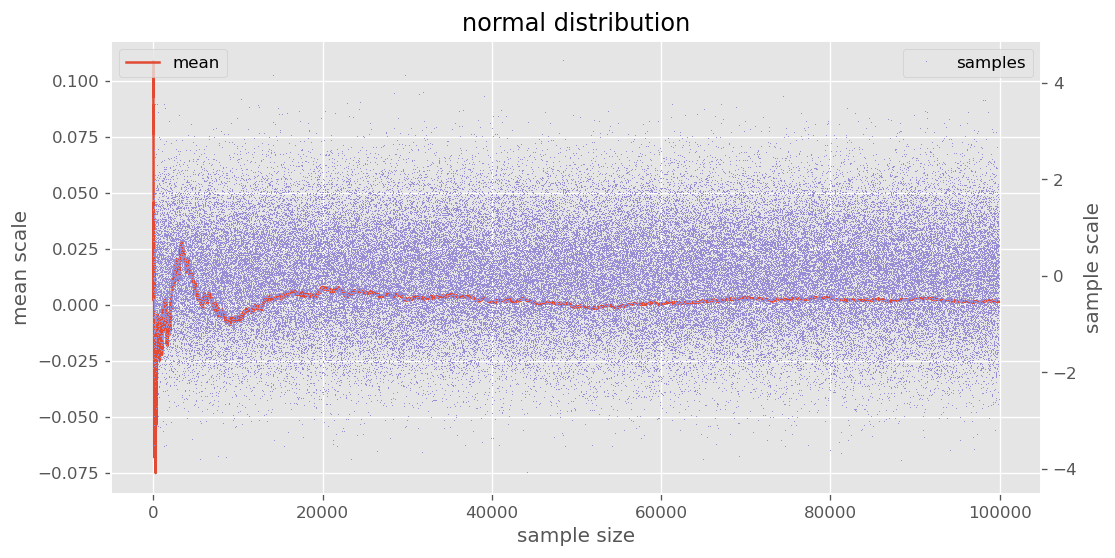

In [6]:
fig, ax = plt.subplots(dpi=120, figsize=[10, 5])
ax_twin = ax.twinx()
ax_twin.grid(False)

ax.plot(normal_mean[100:], color='C0', label="mean")
ax_twin.plot(normal_sample[100:], ',', color='C2', label="samples")

ax.legend(loc="upper left")
ax_twin.legend(loc="upper right")

ax.set(xlabel="sample size", title="normal distribution", ylabel="mean scale")
ax_twin.set(ylabel="sample scale");

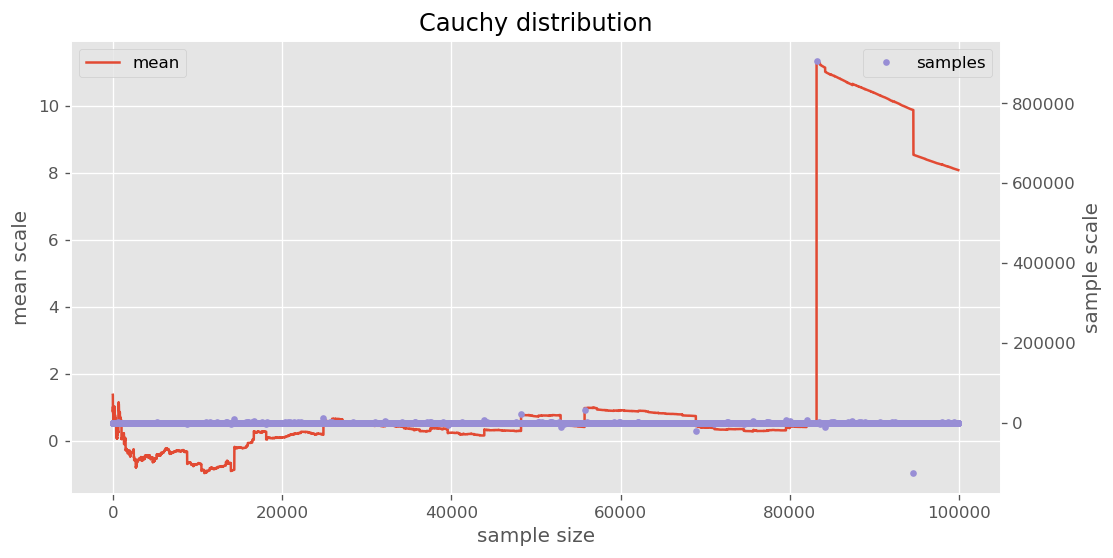

In [8]:
fig, ax = plt.subplots(dpi=120, figsize=[10, 5])
ax_twin = ax.twinx()
ax_twin.grid(False)

ax.plot(cauchy_mean[100:], color='C0', label="mean")
ax_twin.plot(cauchy_sample[100:], '.', color='C2', label="samples")

ax.legend(loc="upper left")
ax_twin.legend(loc="upper right")

ax.set(xlabel="sample size", title="Cauchy distribution", ylabel="mean scale")
ax_twin.set(ylabel="sample scale");

В случае с нормальным распределением видим, что колебания среднего постепенно затухают, и оно становится очень близко к нулю. Для распределения Коши это неверно. Даже для большого размера выборки может добавиться наблюдение, которое значительно нарушит среднее.

## Медиана

Теперь проведем аналогичный эксперимент с медианой:

In [8]:
cauchy_median = cum_median(cauchy_sample)
normal_median = cum_median(normal_sample)

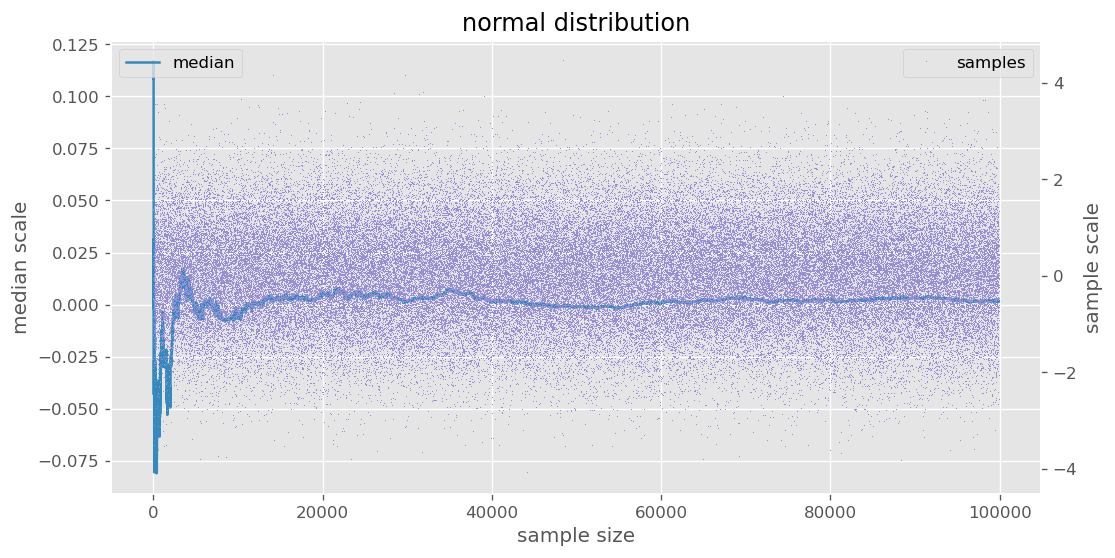

In [9]:
fig, ax = plt.subplots(dpi=120, figsize=[10, 5])
ax_twin = ax.twinx()
ax_twin.grid(False)

ax.plot(normal_median[100:], color='C1', label="median")
ax_twin.plot(normal_sample[100:], ',', color='C2', label="samples")

ax.legend(loc="upper left")
ax_twin.legend(loc="upper right")

ax.set(xlabel="sample size", title="normal distribution", ylabel="median scale")
ax_twin.set(ylabel="sample scale");

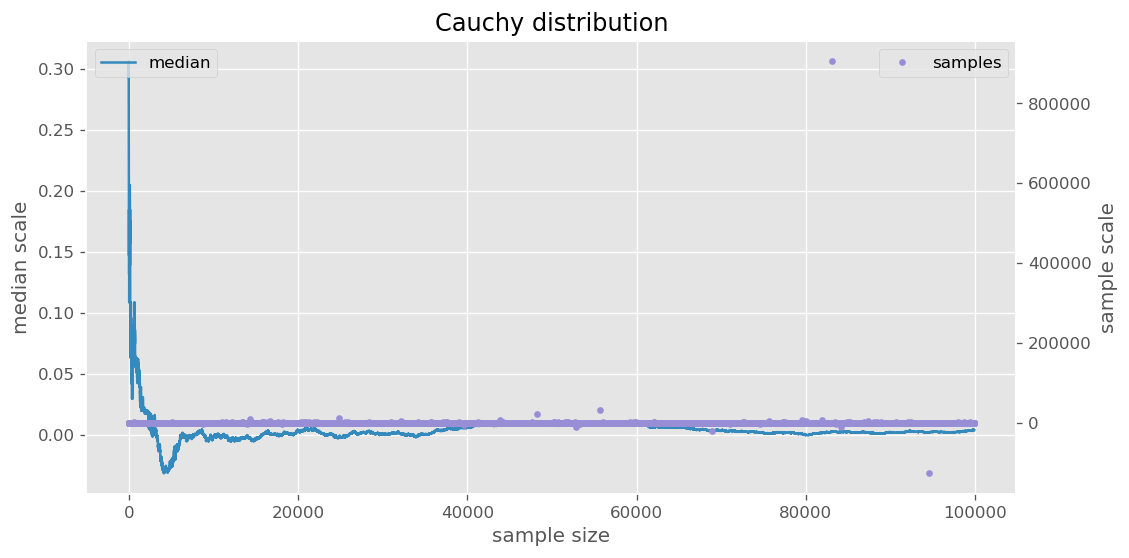

In [10]:
fig, ax = plt.subplots(dpi=120, figsize=[10, 5])
ax_twin = ax.twinx()
ax_twin.grid(False)

ax.plot(cauchy_median[100:], color='C1', label="median")
ax_twin.plot(cauchy_sample[100:], '.', color='C2', label="samples")

ax.legend(loc="upper left")
ax_twin.legend(loc="upper right")

ax.set(xlabel="sample size", title="Cauchy distribution", ylabel="median scale")
ax_twin.set(ylabel="sample scale");

Разброс медианы на том же размере выборки для распределения Коши все равно больше, чем для нормального, однако эта статистика теперь уже сходится к 0 при $n \to \infty$.

# Задача 2

Рассмотрим метод максимального правдоподобия для задачи выпадения решки при бросках монетки. Формально это означает, что мы наблюдаем выборку из биномиального распределения с неизвестным параметром $p$. По аналогии с лекцией запишем:

$$ L(p) = C^x_n p^x (1 - p)^{n-x} $$

где $x$ – число выпадений решки. Будем работать с логарифмом $L(p)$ без учета константы $C^x_n$:

$l(p) = x\ln p + (n - x) \ln (1 - p)$



In [11]:
def l_likelihood(p, sample):
    """
    This function calculates log-likelihood for a sample.

    p : float in [0, 1] or np.array
    sample : array of 0 or 1
    """

    n = len(sample)
    x = np.sum(sample)

    return x * np.log(p) + (n - x) * np.log(1 - p)

Расчитаем функцию правдоподобия на интервале $(0, 1)$:

In [12]:
p = np.linspace(0, 1, 100)[1:-1]   # исключим 0 и 1
n, true_p = 10, 0.33               # истинные значения параметров
sample = np.random.choice(2, size=n, replace=True, p=[1 - true_p, true_p])  # случайная выборка из биномиального распределения

x = np.sum(sample)
p_ml = x / n                       # оценка максимального правдоподобия
l = l_likelihood(p, sample)        # считаем функцию правдоподобия

In [13]:
x

2

In [14]:
n

10

Построим график, который можно интерпретировать следующим образом: для каждого $p$ мы посчитали, насколько *правдоподобно*, что данная выборка была порождена биномиальным распределением с параметром $p$.

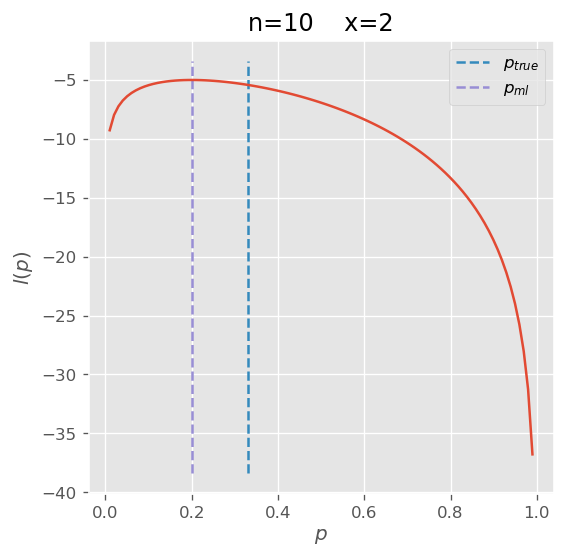

In [15]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=120)

ax.plot(p, l)

ymin, ymax = ax.get_ylim()
ax.vlines(x=true_p, ymin=ymin, ymax=ymax, color="C1", linestyles="dashed", label=r"$p_{true}$")
ax.vlines(x=p_ml, ymin=ymin, ymax=ymax, color="C2", linestyles="dashed", label=r"$p_{ml}$")

ax.set(xlabel=r"$p$", ylabel=r"$l(p)$", title=f"{n=}    {x=}")
ax.legend();

Видим, что максимум действительно достигается в точке $x / n$, и она близка к истинному значению параметра. Обернем код выше в функцию и построим аналогичный график для разных значений $p_{true}$, $n$.

In [16]:
def plot_likelihood(n, true_p):
    sample = np.random.choice(2, size=n, replace=True, p=[1 - true_p, true_p])  # извлекаем выборку

    x = np.sum(sample)
    p_ml = x / n  # считаем оценку макс правдоподобия
    l = l_likelihood(p, sample)

    _, ax = plt.subplots(figsize=[5, 5], dpi=120)  # строим график

    ax.plot(p, l)

    ymin, ymax = ax.get_ylim()
    ax.vlines(x=true_p, ymin=ymin, ymax=ymax, color="C1", linestyles="dashed", label=r"$p_{true}$")
    ax.vlines(x=p_ml, ymin=ymin, ymax=ymax, color="C2", linestyles="dashed", label=r"$p_{ml}$")

    ax.set(xlabel=r"$p$", ylabel=r"$l(p)$", title=f"{n=}    {x=}")
    ax.legend()
    plt.show();

В графиках ниже очень важно обращать внимание на ось $y$ и ее масштаб! Иначе может показаться, что форма графика не меняется для разных размеров выборки. 

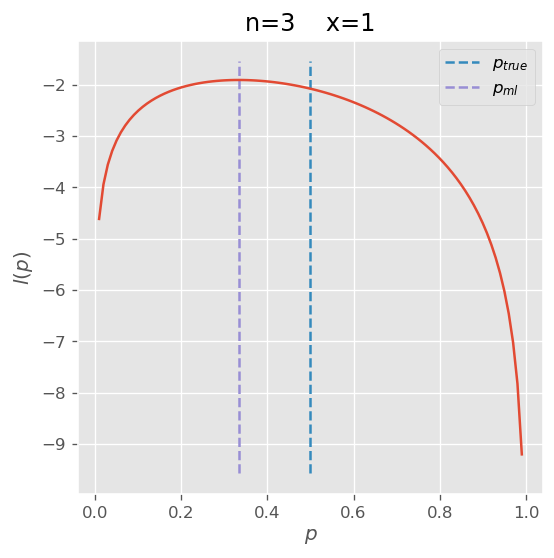

In [17]:
plot_likelihood(n=3, true_p=0.5)

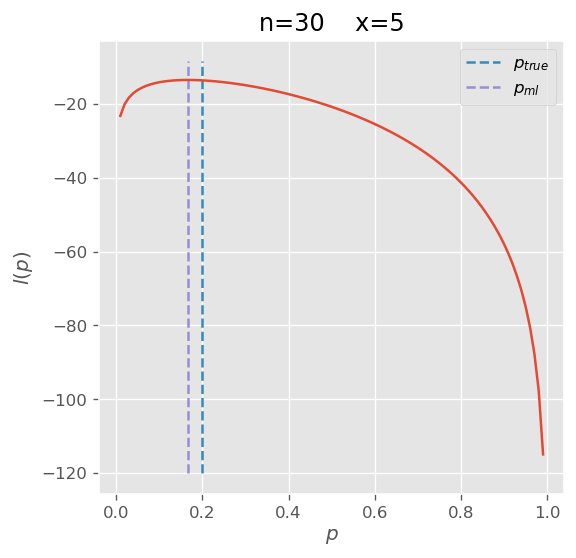

In [18]:
plot_likelihood(n=30, true_p=0.2)

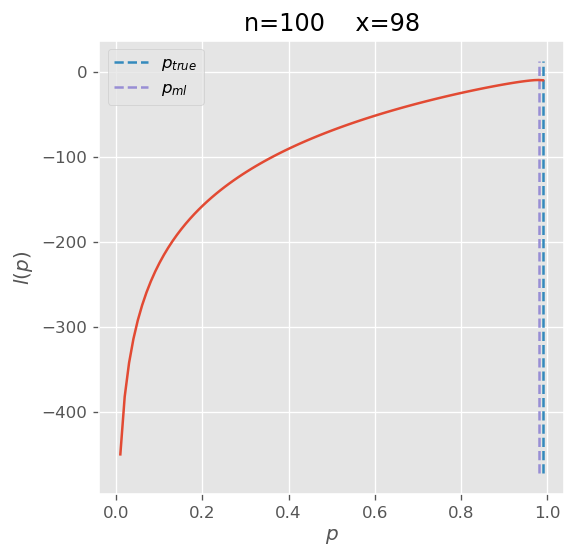

In [19]:
plot_likelihood(n=100, true_p=0.99)

Можно видеть, как с ростом размера выборки оценка $p_{ml}$ в среднем приближается к истинному значению параметра $p_{true}$.

В реальных задачах функции правдоподобия иногда невозможно максимизировать аналитически. Например, при обучении логистической регрессии.

Рассмотрим простой пример численной оптимизации правдоподобия. Зафиксируем некоторую выборку и получим $f(p)$ – функцию одного аргумента для оптимизации:

In [20]:
sample = np.array([0, 1, 1, 1, 0, 0, 1, 1])     # зафиксируем выборку
f = lambda p: - l_likelihood(p, sample=sample)  # функция правдоподобия для этой выборки со знаком минус (чтобы минимизировать специальной функцией)
print(f"Negative log-likelihood at p=0.5: {f(0.5):.4f}")

Negative log-likelihood at p=0.5: 5.5452


In [21]:
f(0)

<ipython-input-11-67c92e2d3985>:12: RuntimeWarning: divide by zero encountered in log
  return x * np.log(p) + (n - x) * np.log(1 - p)


inf

In [22]:
f(1)

<ipython-input-11-67c92e2d3985>:12: RuntimeWarning: divide by zero encountered in log
  return x * np.log(p) + (n - x) * np.log(1 - p)


inf

Будем использовать простейший способ оптимизации в `scipy`:

In [23]:
from scipy.optimize import minimize
eps = 1e-6

minimize(
    fun=f,                       # The objective function to be minimized.
    x0=0.5,                      # Initial guess
    bounds=[(0 + eps, 1 - eps)]  # Bounds on variables 
)

      fun: array([5.29250591])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([0.62499999])

Получили $\hat p=0.625$. Сравним с аналитическим решением:

In [24]:
np.mean(sample)

0.625

# Домашнее задание

**Дедлайн – 09.03 23:59**

## Задача 1

Возьем распределение Парето: $$p(x) = \frac{k}{x^{k+1}}$$

Матожидание равно $$\mathbb E [X] = \frac{k}{k-1},\; k > 1$$

Найдем оценку методом моментов: заменим матожидание на его приближение выборочным средним, а $k$ – на оценку $\hat k$: $$\overline x = \frac{\hat k}{\hat k-1}$$

Выражаем $\hat k$ и получем оценку методом моментов: $$\hat k = \frac{\overline x}{\overline x - 1}$$

Рассмотрим два случая: $k=1$ и $k=2$. Для каждого случая нужно
 - сгенерировать выборку из распределения Парето с данным значением параметра (размер $n=100000$)
 - построить накопленную оценку методом моментов
 - сделать вывод, сходится ли она к истинному значению параметра

Перед генерацией фиксируйте сид для воспроизводимости результатов. Пример в этом ноутбуке.

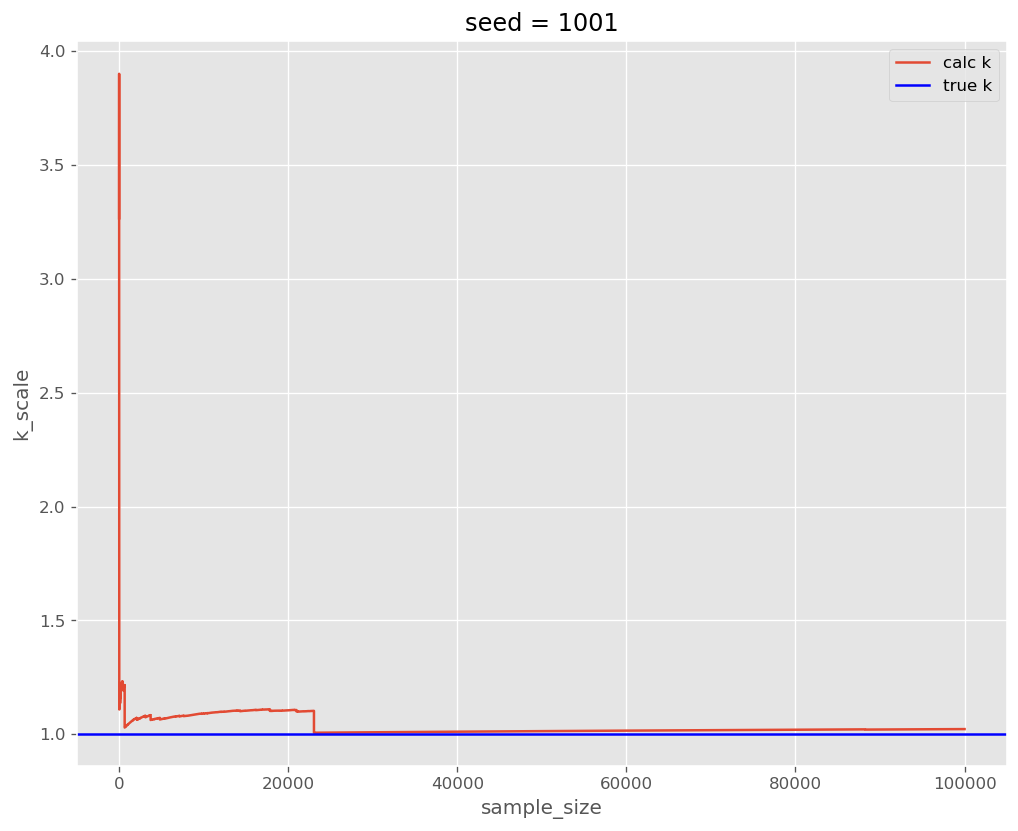

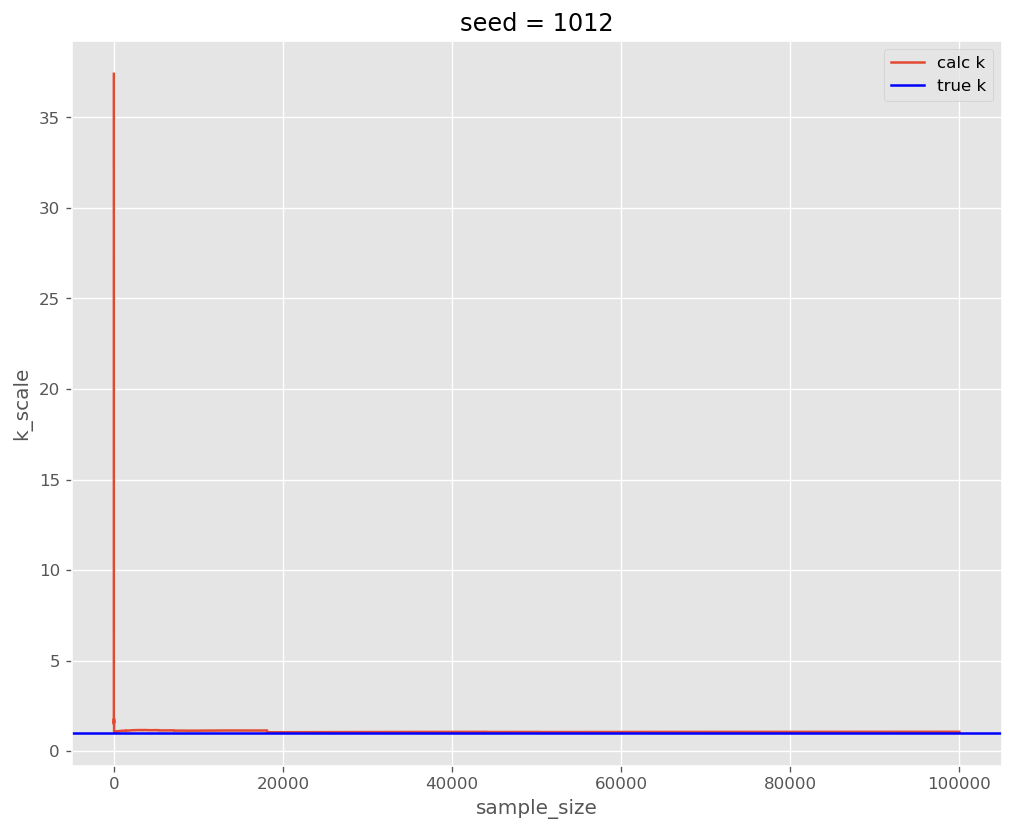

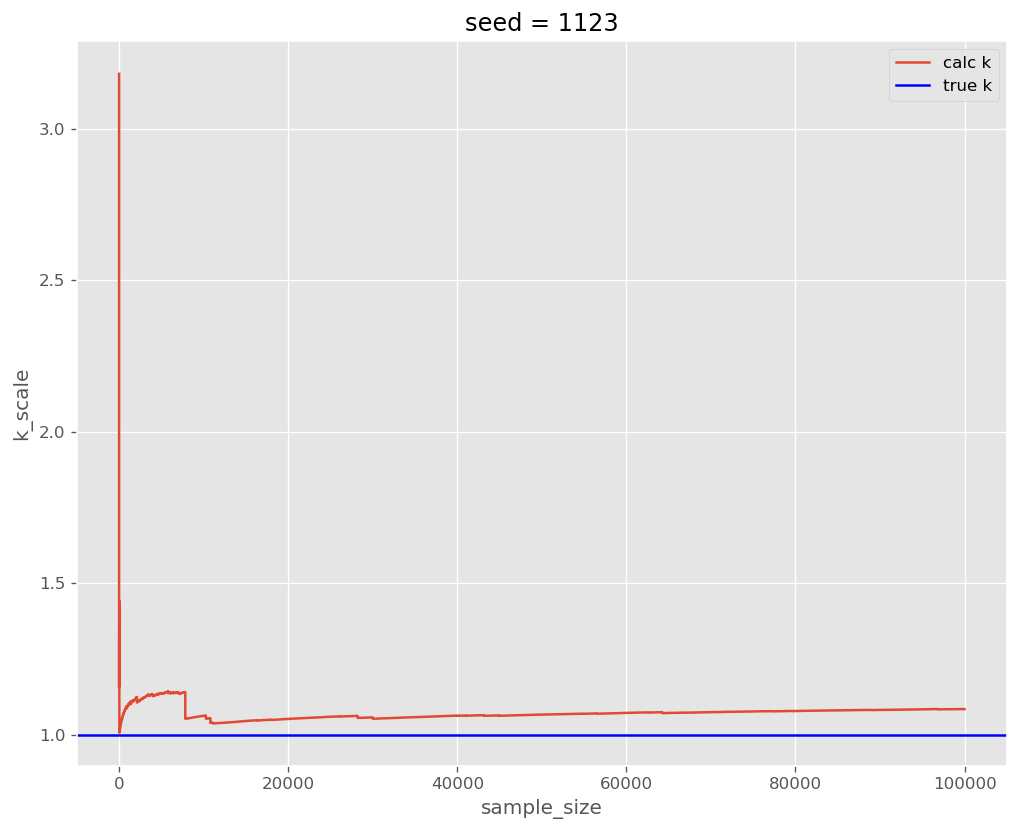

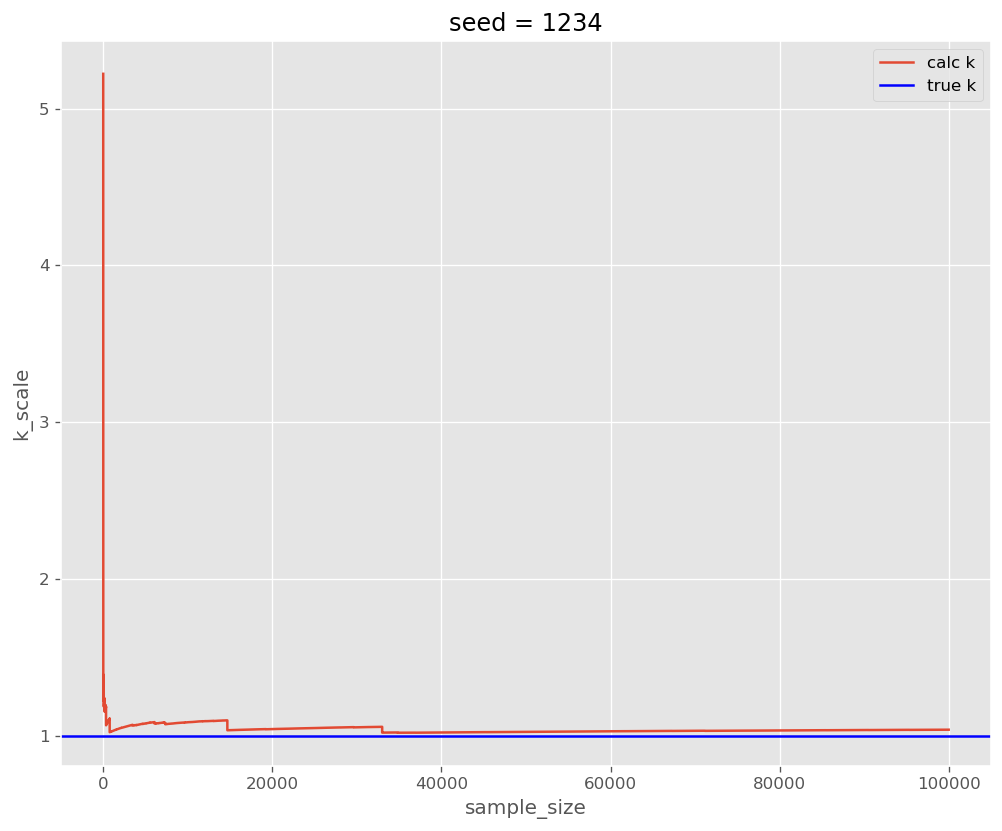

In [17]:
#воспользуемся семинарскими функциями
cum_mean = lambda x: np.cumsum(x) / np.arange(1, len(x) + 1)  # thanks, stackoverflow

k=1
n=100000
for seed in [1001, 1012, 1123, 1234]:
    np.random.seed(seed)
    pareto_sample = stats.pareto.rvs(k,size=n)
    k_numerical = cum_mean(pareto_sample) / (cum_mean(pareto_sample) - 1)
    fig, ax = plt.subplots(dpi=120,figsize=(10,8))
    ax.plot(k_numerical, label='calc k')
    ax.set_title(f'seed = {seed}')
    ax.set_xlabel('sample_size')
    ax.set_ylabel('k_scale')
    ax.axhline(k, label='true k', c='b')
    plt.legend()

При k=1 формула E[X] для распределения Парето не действительна => при таких условиях оценка параметра k методом моментов не будет достоверной и сходимость оценки к истинному значению не произойдёт

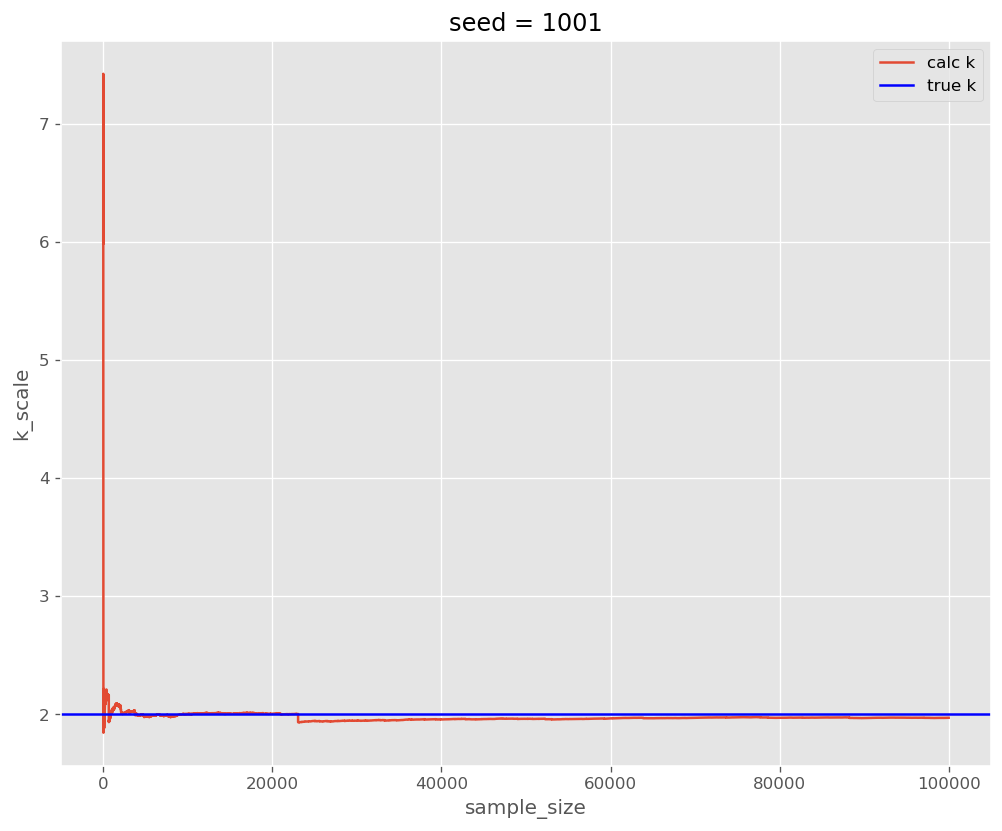

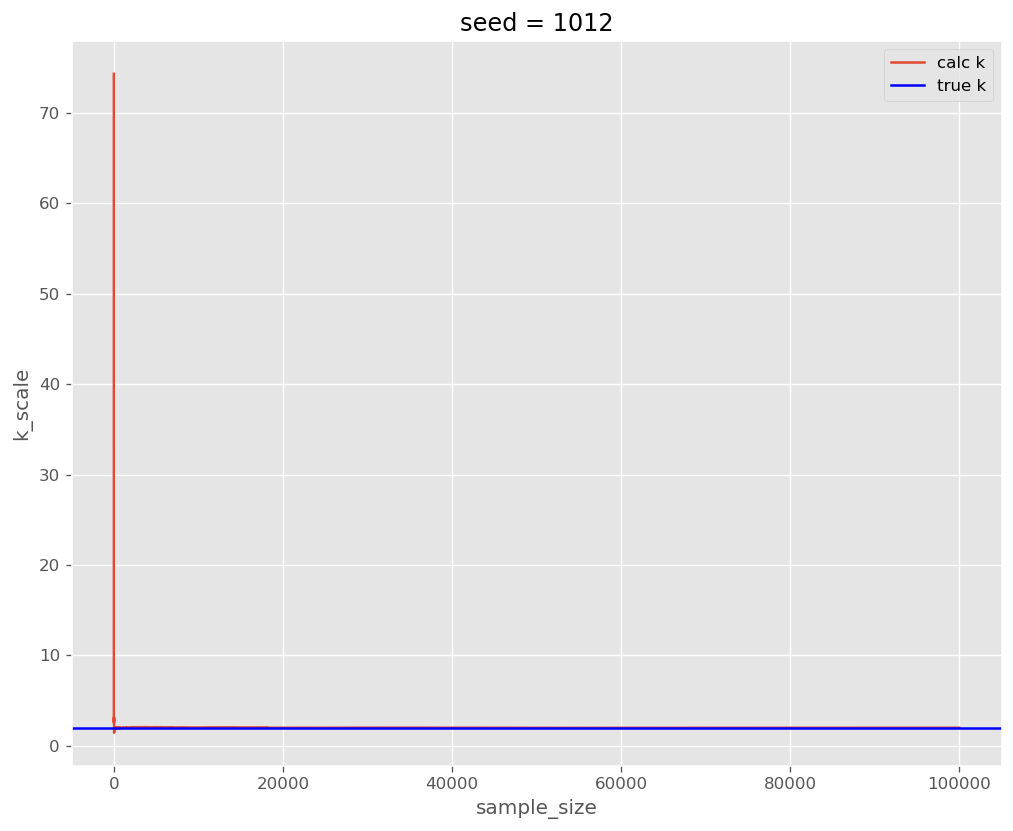

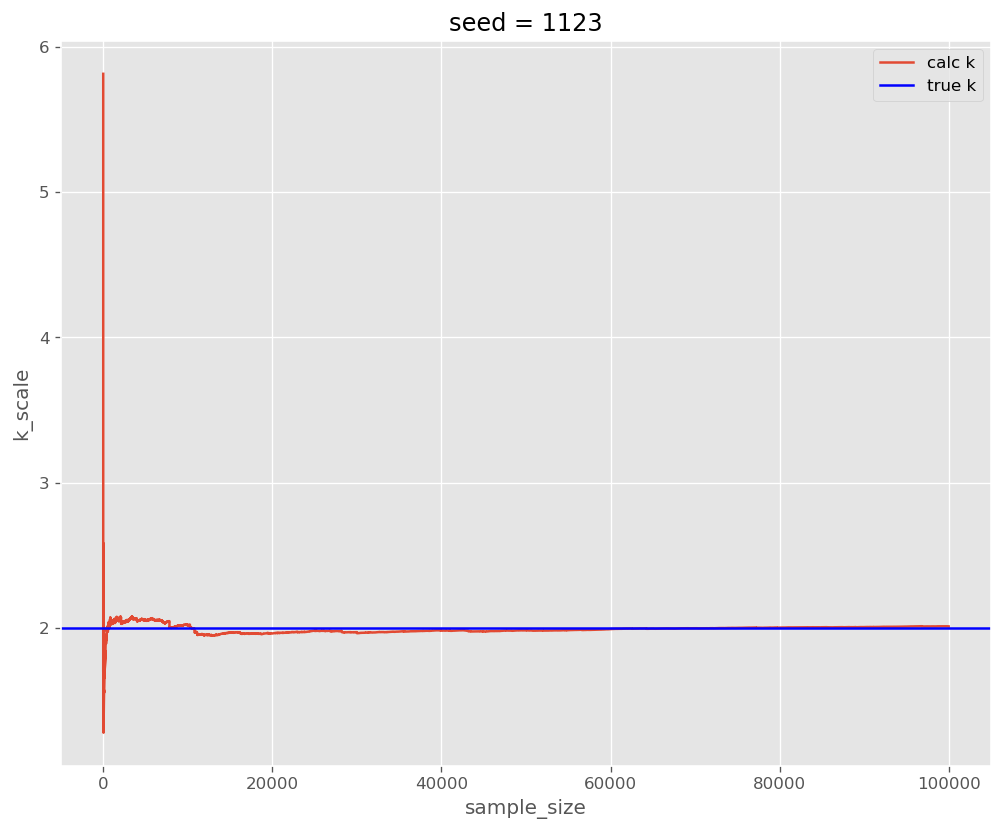

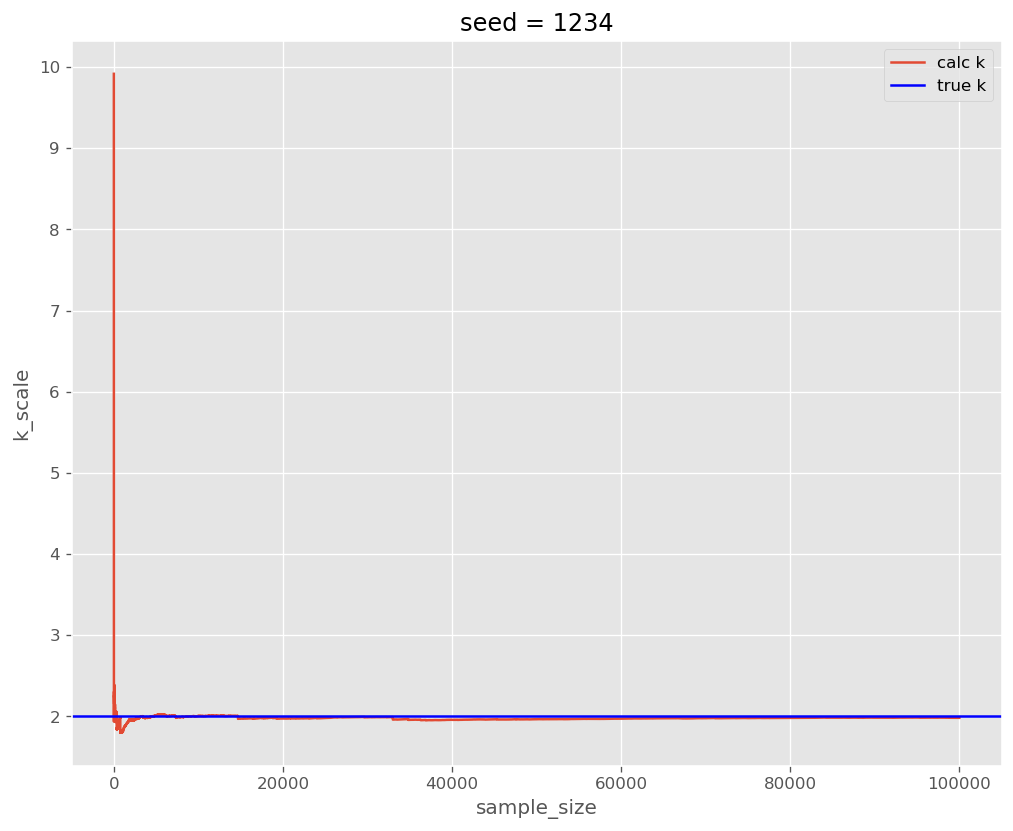

In [18]:
k=2
n=100000
for seed in [1001, 1012, 1123, 1234]:
    np.random.seed(seed)
    pareto_sample = stats.pareto.rvs(k,size=n)
    k_numerical = cum_mean(pareto_sample) / (cum_mean(pareto_sample) - 1)
    fig, ax = plt.subplots(dpi=120,figsize=(10,8))
    ax.plot(k_numerical, label='calc k')
    ax.set_title(f'seed = {seed}')
    ax.set_xlabel('sample_size')
    ax.set_ylabel('k_scale')
    ax.axhline(k, label='true k', c='b')
    plt.legend()

Случай k=2, наоборот, удовлетворяет условию существования E[X] по формуле распределения Парето (E[X] = k/(k-1) = 2)

С увеличением выборки $\overline x \to E\left [X \right ]$ при $n \to \infty$, следовательно, $\hat k = \overline x \ /\ (\overline x - 1) \to 2 \ /\ (2 - 1) = 2$ при $n \to \infty$

## Задача 2

Рассмотрим модель с лекции с выборкой `x = np.array([0.164, 0.395, 0.113, 0.401, 0.287, 1.757])` и экспоненциальным распределением:

$$
l(\lambda) = n \ln \lambda - \lambda \sum_{i=1}^{n} x_i
$$

Требуется:

- реализовать функцию `l_likelihood` для данной модели по аналогии с функцией для семинара.
- построить ее график для $0 \leq \lambda \leq 7$
- оптимизировать с помощью `scipy.optimize.minimize` для выборки, данной выше, и сравнить с аналитическим решением.

In [32]:
def l_likelihood(l, sample):
    
    n = len(sample)
    sum_x = np.sum(sample)
    return n * np.log(l) - l * sum_x

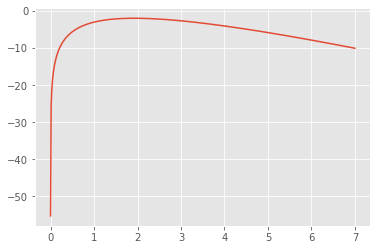

In [33]:
ls = np.linspace(0.0001,7,500)
x = np.array([0.164, 0.395, 0.113, 0.401, 0.287, 1.757])
plt.plot(ls, [l_likelihood(l,x) for l in ls]);

In [34]:
from scipy.optimize import minimize
lambda_analytic = 1 / x.mean() #фналитическое решение

eps=1e-6
l_lamb_x = lambda l: - l_likelihood(l, sample=x)
res = minimize(fun=l_lamb_x, x0=3, bounds=[(0 + eps, 10 - eps)])
if res.success:
    print('lambda: \n', f'analytical solve: {lambda_analytic}\n', f'numerical solve: {res.x[0]}\n', f'error is {abs(lambda_analytic - res.x)[0]}')

lambda: 
 analytical solve: 1.9249278152069298
 numerical solve: 1.9249278227673041
 error is 7.560374326587294e-09
